# **Depicting The 1947 Partition of India and Pakistan Using Neural Style Transfer**

Viraj, Udayan, and my project topic of choice is the bloody partition of India and Pakistan, which occurred in 1947. We hope to represent not only the trauma that both sides have dealt with over the years, but how they have healed as well. This guiding vision drives many of the creative decisions that we make throughout the creation of this art work.

---




**Neural Style Transfer**

Neural Style Transfer(NST), introduced in *A Neural Algorithm of Artistic Style*(Gatys et al. 2015), is a popular algorithm that involves the use of Artificial Intelligence(AI) models to "manipulate digital images, or videos, in order to adopt the appearance or visual style of another image". With Neural Style Transfer, you essentially feed the AI model two images, a **content image** and a **style image**. The AI model then outputs a completely new image, with the original content presented in the style of the given style image(as seen in the image below). Due to my prior experience working with similar models in the past, we felt that Neural Style Transfer could be a very powerful medium to convey our message. My implementation of the NST algorithm along with some helpful annotations are present below.

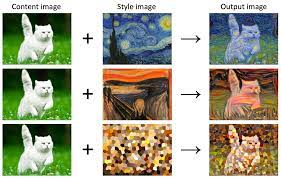



---



---



## Setup

First, we have to import and configure some necessary modules.

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Now, we have to specify the path to the **content and style images**.

In [ ]:
content_path = '/content/content_img.jpeg'
style_path = '/content/style-img.jpg'

## Visualizing The Inputs

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Now, lets define a simple function that will display the style and content images:

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

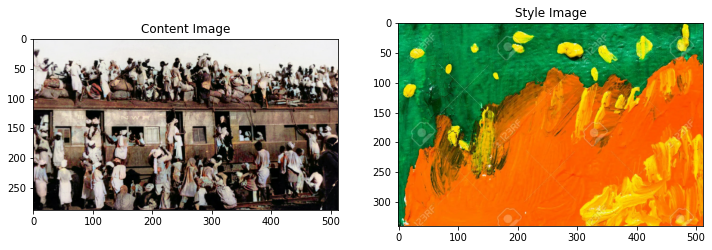

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

  For our content image, we went with a colorized version of the most iconic photograph of the Partition which depicts hundreds upon hundreds of refugees packed into(and on top of) a train, forced to leave all of their possessions amidst a highly uncertain journey. This image has come to represent the trauma that both Indian and Pakistani people faced during the Partition.

  As for the style image, we went with a gradient color scheme with heavy themes of orange and green present throughout. For the style image, our intention was to use the dominant colors of the Indian and Pakistani flags, and combine them together in a gradient to symbolize a need for unity between the two nations. It is overwhelmingly clear that in order for both groups to fully heal from mistakes of the past, they must forgive each other in the present.

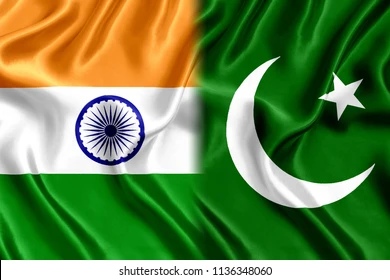

## Defining Content and Style Representations

From a relevant tutorial by Google:

"Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers."


---



---



Now, lets load our AI model of choice(VGG-19) which is essential to implement NST.

In [ ]:
from IPython.core.display import clear_output
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)



input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Now, we have to select some portions of VGG-19 to represent the style and content of the image.

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

##### So What Do These Layers Do Anyway?

**Again, from the Google tutorial:**

"So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images."

## Building The Model 

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Now we can create the model using the below code:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 341, 512, 64)
  min:  0.0
  max:  758.54517
  mean:  47.247337

block2_conv1
  shape:  (1, 170, 256, 128)
  min:  0.0
  max:  5185.058
  mean:  182.10948

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  9856.642
  mean:  165.50423

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  20059.76
  mean:  644.0935

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  4268.339
  mean:  50.444225



## Calculating Style

"The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:"

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extracting The Style and Content Images From The Model

The following block builds the model:

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

Now, we have the style and content images.

## Optimizing The Model To Create Partition Artwork

First, we have to set our desired style and content images as well as fulfill some implementational requirements as advised in the original paper

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Now, we have to instantiate our optimizer as well as the relative importance of the style and content images.

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=2e-2
content_weight=1e4

Next, we have to define our optimization objective and training step:

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Finally, we can use Neural Style Transfer to create Partition Artwork!



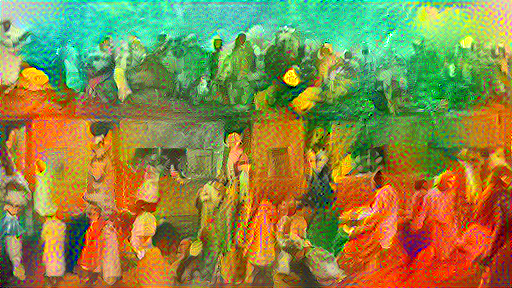

Train step: 2000
Total time: 387.8


In [ ]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

Now, we need to save this image to our computer.

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After running all of the above cells and performing some post-processing techniques, here is our final product!:

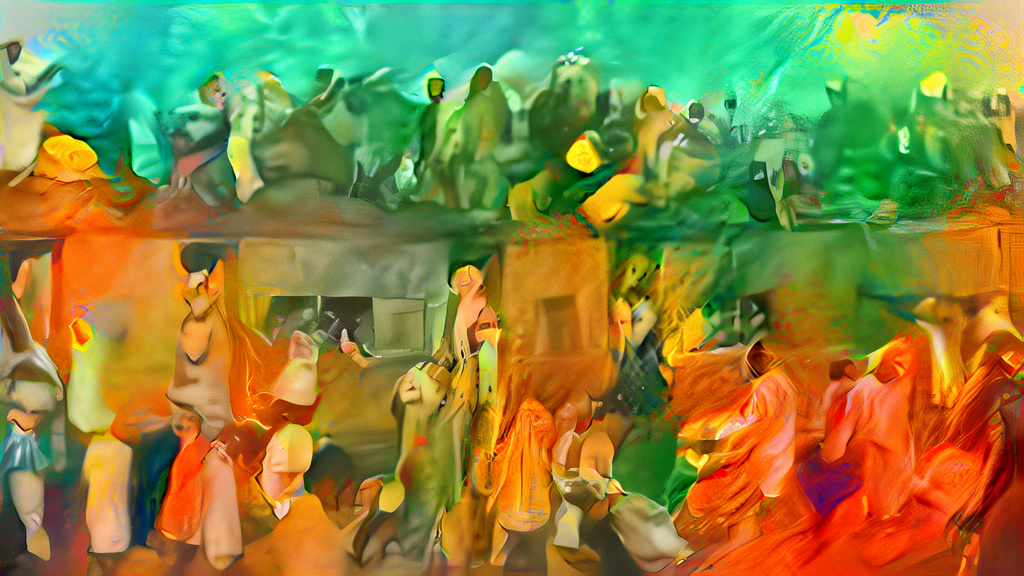

## References

https://arxiv.org/pdf/1508.06576.pdf

https://www.tensorflow.org/tutorials/generative/style_transfer

https://letsenhance.io/

https://deepai.org/machine-learning-model/colorizer